Wrote: COOPS8654467_hindcast_hourly.csv

Overall (where obs exist): n=136461, r=0.428, bias=-0.000 m, rmse=0.134 m
Wrote: COOPS8654467_top20_hindcast_events_summary.csv
Wrote: COOPS8654467_top20_event_slices_hourly.csv

Top events summary:
 rank             peak_time_utc  wl_pred_peak_m  n_obs_overlap  bias_m  rmse_m   r
    1 1958-09-28 04:00:00+00:00        4.895494              0     NaN     NaN NaN
    2 1980-03-25 02:00:00+00:00        4.121277              0     NaN     NaN NaN
    3 1980-07-04 08:00:00+00:00        4.121277              0     NaN     NaN NaN
    4 1979-12-02 04:00:00+00:00        4.121277              0     NaN     NaN NaN
    5 1981-03-27 07:00:00+00:00        4.121277              0     NaN     NaN NaN
    6 1993-08-31 22:00:00+00:00        3.705547              0     NaN     NaN NaN
    7 1985-09-27 07:00:00+00:00        3.440969              0     NaN     NaN NaN
    8 1976-07-11 22:00:00+00:00        3.415065              0     NaN     NaN NaN
    9 1981-06

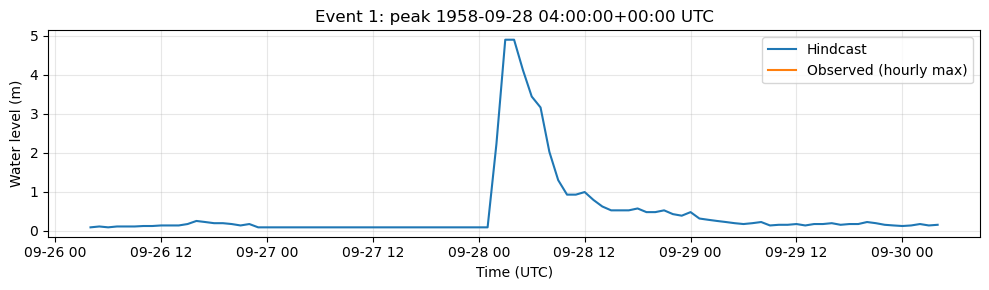

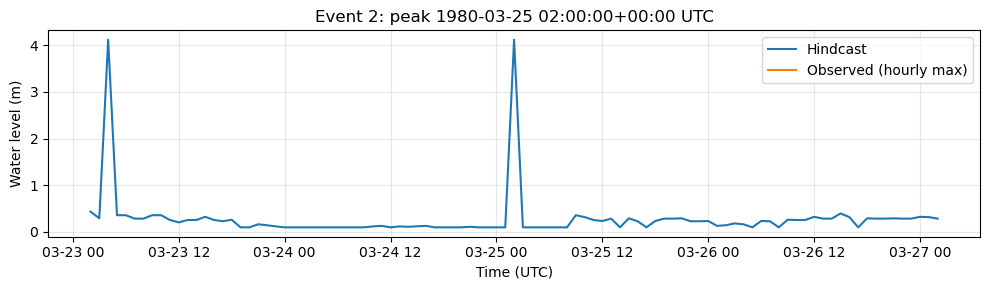

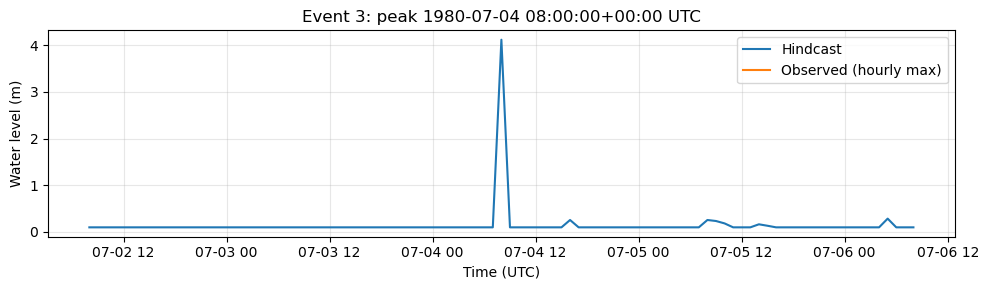

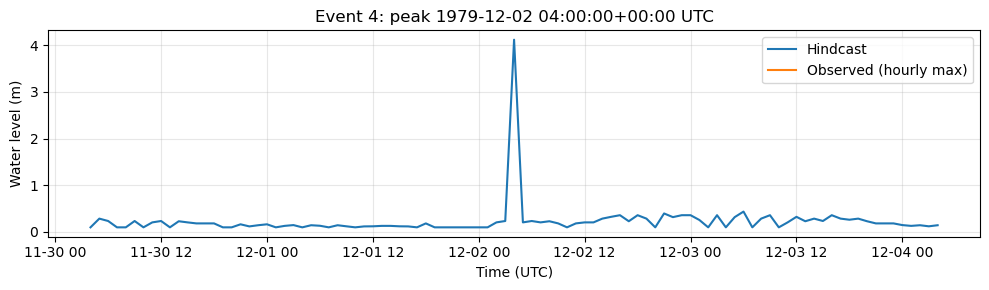

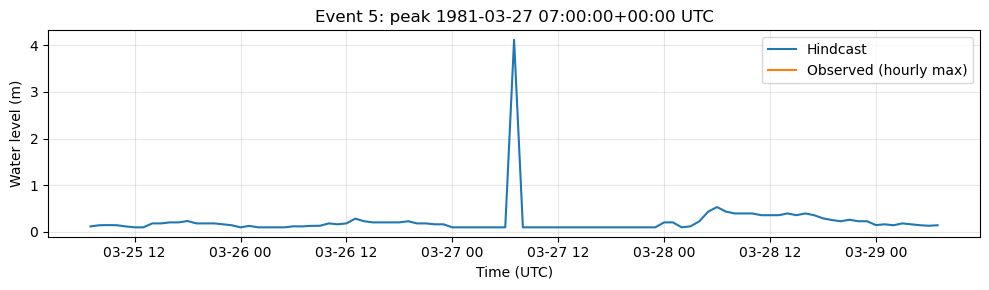

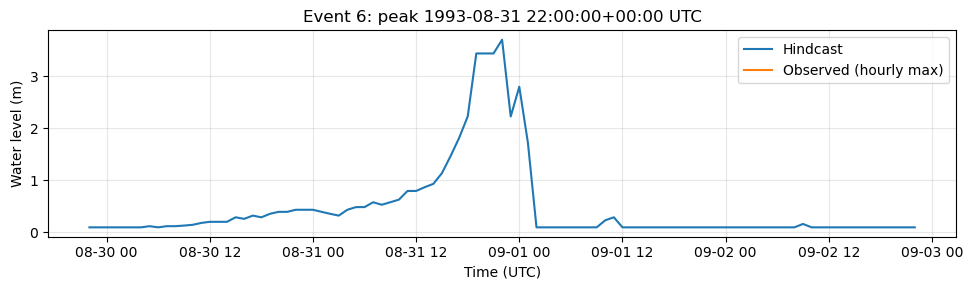


Annual-max return interval (hindcast):
 year  annual_max_hindcast_m  rank  return_period_yr
 1958               4.895494     1         70.000000
 1981               4.121277     2         35.000000
 1979               4.121277     3         23.333333
 1980               4.121277     4         17.500000
 1993               3.705547     5         14.000000
 1985               3.440969     6         11.666667
 1976               3.415065     7         10.000000
 2005               3.095963     8          8.750000
 1961               2.918101     9          7.777778
 2003               2.385587    10          7.000000
 1991               2.227331    11          6.363636
 1982               2.025125    12          5.833333
 1983               2.025125    13          5.384615
 1973               2.005457    14          5.000000
 1994               1.814318    15          4.666667


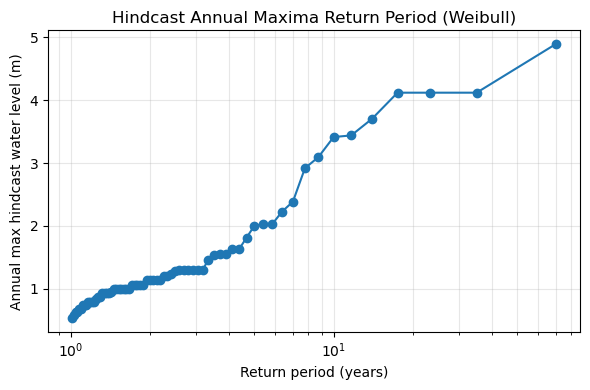

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# INPUTS
# ============================================================
WIND_CSV = "KHSE_merged_with_COOPSfill_regimeAware_hourly.csv"
WL6_CSV  = "coops_8654467/COOPS_8654467_water_level_6min_MSL_metric_GMT.csv"

# ============================================================
# MODEL COEFFICIENTS (YOU PROVIDE THESE)
# ============================================================
# Model: wl_pred(t) = a * U2_sector(t - lag_h) + b
# 0.005029 * U2(t-0h) + 0.09281
a = 0.00503          # <-- set your fitted slope
b = 0.0928          # <-- set your fitted intercept
lag_h = 0        # <-- set your fitted lag in hours (wind leads WL)

# Sector choice: "NW" or "NWNE"
SECTOR = "NWNE"

# ============================================================
# SETTINGS
# ============================================================
FREQ = "1h"
OUT_HINDCAST_CSV   = "COOPS8654467_hindcast_hourly.csv"
OUT_TOP_EVENTS_CSV = "COOPS8654467_top20_hindcast_events_summary.csv"
OUT_EVENT_SLICES_CSV = "COOPS8654467_top20_event_slices_hourly.csv"

MIN_PEAK_SEP_H = 48       # decluster peaks (hours)
EVENT_WINDOW_H = 48       # +/- window around each peak for obs-vs-model comparison
MIN_POINTS_FOR_STATS = 24 # minimum overlapping hours to compute stats
TOP_N = 20

# ============================================================
# HELPERS
# ============================================================
def mask_sector(dfrom_deg, sector="NWNE"):
    d = (dfrom_deg % 360.0)
    if sector.upper() == "NW":
        return (d >= 270.0) & (d < 360.0)
    if sector.upper() == "NWNE":
        return (d >= 270.0) | (d < 90.0)
    raise ValueError("sector must be 'NW' or 'NWNE'")

def stats_block(obs, pred):
    d = pd.concat([obs, pred], axis=1).dropna()
    if len(d) < MIN_POINTS_FOR_STATS:
        return dict(n=len(d), bias=np.nan, rmse=np.nan, r=np.nan)
    o = d.iloc[:,0].values.astype(float)
    p = d.iloc[:,1].values.astype(float)
    err = p - o
    return dict(
        n=len(d),
        bias=float(err.mean()),
        rmse=float(np.sqrt((err**2).mean())),
        r=float(np.corrcoef(o, p)[0,1]),
    )

def event_peaks(series, top_n=20, min_sep_hours=48):
    s = series.dropna().copy()
    if len(s) == 0:
        return []
    cand = s.sort_values(ascending=False)
    chosen = []
    min_sep = pd.Timedelta(hours=min_sep_hours)
    for t, val in cand.items():
        if all(abs(t - tc) > min_sep for tc, _ in chosen):
            chosen.append((t, float(val)))
            if len(chosen) >= top_n:
                break
    return chosen

# ============================================================
# 1) LOAD HOURLY WINDS (MERGED SERIES)
# ============================================================
w = pd.read_csv(WIND_CSV, parse_dates=["time"])
w["time"] = pd.to_datetime(w["time"], utc=True, errors="coerce")
w = w.dropna(subset=["time"]).set_index("time").sort_index()

U = pd.to_numeric(w["wind_speed_mps"], errors="coerce")
D = pd.to_numeric(w["wind_dir_from_deg"], errors="coerce")

# ensure hourly grid
U = U.resample(FREQ).mean()
D = D.resample(FREQ).mean()  # direction mean isn't physically perfect, but OK if already hourly
# If you want strict vector-mean direction, use u/v columns if you saved them.

# ============================================================
# 2) BUILD SECTOR FORCING (U^2 in-sector else 0), LAG, HINDCAST
# ============================================================
m = mask_sector(D.values, sector=SECTOR)
U2 = U**2
U2_sector = U2.where(m, 0.0)

U2_lagged = U2_sector.shift(int(lag_h))
wl_pred = a * U2_lagged + b
wl_pred.name = "wl_pred"

# ============================================================
# 3) LOAD WL (6-min) AND RESAMPLE TO HOURLY MAX
# ============================================================
wl = pd.read_csv(WL6_CSV, parse_dates=["Date Time"])
wl["time"] = pd.to_datetime(wl["Date Time"], utc=True, errors="coerce")
wl = wl.dropna(subset=["time"]).set_index("time").sort_index()
wl = wl.dropna(subset=["Date Time"])
wl["wl"] = pd.to_numeric(wl["Water Level"], errors="coerce")

wl_hr_max = wl["wl"].resample(FREQ).mean()
wl_hr_max.name = "wl_obs_hr_max"

# ============================================================
# 4) COMBINE AND WRITE HINDCAST DATASET
# ============================================================
hind = pd.concat([U, D, U2_sector, U2_lagged, wl_pred, wl_hr_max], axis=1)
hind.columns = ["U_mps", "Dfrom_deg", "U2_sector", "U2_sector_lagged", "wl_pred_m", "wl_obs_hr_max_m"]

hind.to_csv(OUT_HINDCAST_CSV, index_label="time")
print("Wrote:", OUT_HINDCAST_CSV)

# Overall stats where observed exists
st_all = stats_block(hind["wl_obs_hr_max_m"], hind["wl_pred_m"])
print(f"\nOverall (where obs exist): n={st_all['n']}, r={st_all['r']:.3f}, bias={st_all['bias']:.3f} m, rmse={st_all['rmse']:.3f} m")

# ============================================================
# 5) TOP EVENTS + OBS COMPARISON WINDOWS
# ============================================================
peaks = event_peaks(hind["wl_pred_m"], top_n=TOP_N, min_sep_hours=MIN_PEAK_SEP_H)

rows = []
slice_rows = []

for rank, (tpk, pk) in enumerate(peaks, start=1):
    t1 = tpk - pd.Timedelta(hours=EVENT_WINDOW_H)
    t2 = tpk + pd.Timedelta(hours=EVENT_WINDOW_H)
    sub = hind.loc[t1:t2, ["wl_obs_hr_max_m", "wl_pred_m", "U_mps", "Dfrom_deg", "U2_sector_lagged"]].copy()
    st = stats_block(sub["wl_obs_hr_max_m"], sub["wl_pred_m"])

    rows.append({
        "rank": rank,
        "peak_time_utc": tpk,
        "wl_pred_peak_m": pk,
        "n_obs_overlap": st["n"],
        "bias_m": st["bias"],
        "rmse_m": st["rmse"],
        "r": st["r"],
    })

    sub_out = sub.reset_index()
    sub_out["event_rank"] = rank
    sub_out["event_peak_time_utc"] = tpk
    slice_rows.append(sub_out)

events = pd.DataFrame(rows)
events.to_csv(OUT_TOP_EVENTS_CSV, index=False)
print("Wrote:", OUT_TOP_EVENTS_CSV)

event_slices = pd.concat(slice_rows, ignore_index=True) if len(slice_rows) else pd.DataFrame()
event_slices.to_csv(OUT_EVENT_SLICES_CSV, index=False)
print("Wrote:", OUT_EVENT_SLICES_CSV)

print("\nTop events summary:")
print(events.to_string(index=False))

# Plot obs vs pred for first few events
for rank in range(1, min(6, len(peaks)) + 1):
    tpk = pd.to_datetime(events.loc[events["rank"] == rank, "peak_time_utc"].values[0], utc=True)
    t1 = tpk - pd.Timedelta(hours=EVENT_WINDOW_H)
    t2 = tpk + pd.Timedelta(hours=EVENT_WINDOW_H)
    sub = hind.loc[t1:t2, ["wl_obs_hr_max_m", "wl_pred_m"]]

    plt.figure(figsize=(10,3))
    plt.plot(sub.index, sub["wl_pred_m"], label="Hindcast")
    plt.plot(sub.index, sub["wl_obs_hr_max_m"], label="Observed (hourly max)")
    plt.title(f"Event {rank}: peak {tpk} UTC")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Water level (m)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# 6) RETURN INTERVAL (ANNUAL MAXIMA, HINDCAST)
# ============================================================
am = hind["wl_pred_m"].dropna().groupby(hind.index.year).max().dropna()
am_sorted = am.sort_values(ascending=False)

n = len(am_sorted)
rank = np.arange(1, n+1)
T = (n + 1) / rank  # Weibull plotting position

ri = pd.DataFrame({
    "year": am_sorted.index.astype(int),
    "annual_max_hindcast_m": am_sorted.values,
    "rank": rank,
    "return_period_yr": T
})

print("\nAnnual-max return interval (hindcast):")
print(ri.head(15).to_string(index=False))

plt.figure(figsize=(6,4))
plt.semilogx(ri["return_period_yr"], ri["annual_max_hindcast_m"], marker="o", linestyle="-")
plt.xlabel("Return period (years)")
plt.ylabel("Annual max hindcast water level (m)")
plt.title("Hindcast Annual Maxima Return Period (Weibull)")
plt.grid(alpha=0.3, which="both")
plt.tight_layout()
plt.show()


Top observed events (declustered):
 1. 2016-10-09 10:00:00+00:00  obs_peak=1.788 m   max_pred_in_window=0.930 m
 2. 2019-09-06 15:00:00+00:00  obs_peak=1.658 m   max_pred_in_window=0.841 m
 3. 2016-09-03 17:00:00+00:00  obs_peak=1.394 m   max_pred_in_window=0.829 m
 4. 2010-09-03 09:00:00+00:00  obs_peak=1.267 m   max_pred_in_window=1.231 m
 5. 2012-10-29 03:00:00+00:00  obs_peak=1.205 m   max_pred_in_window=0.866 m


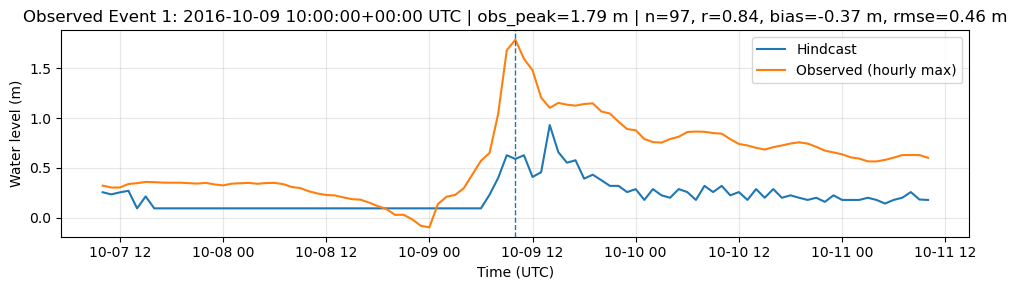

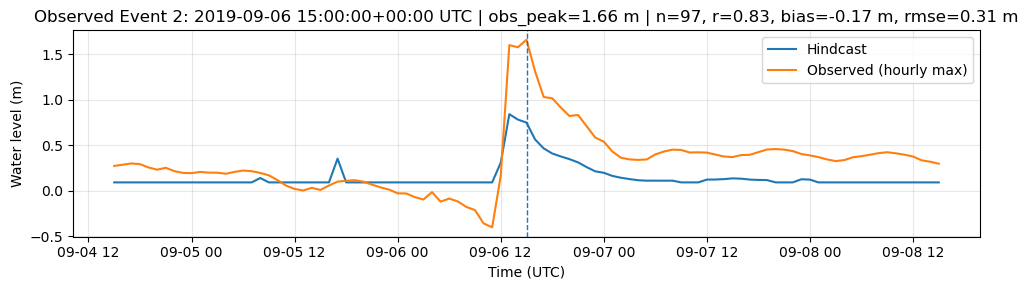

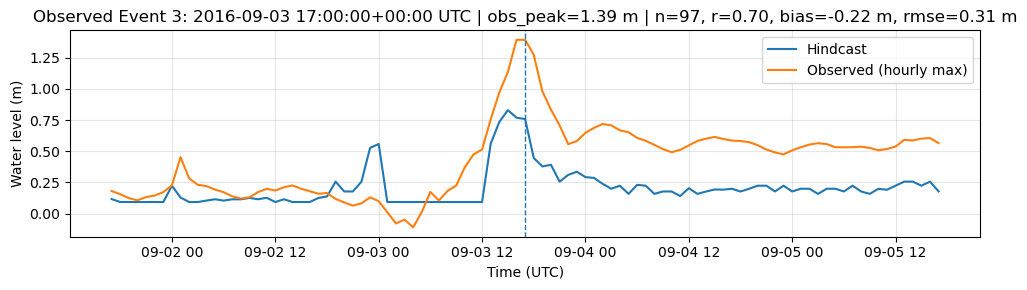

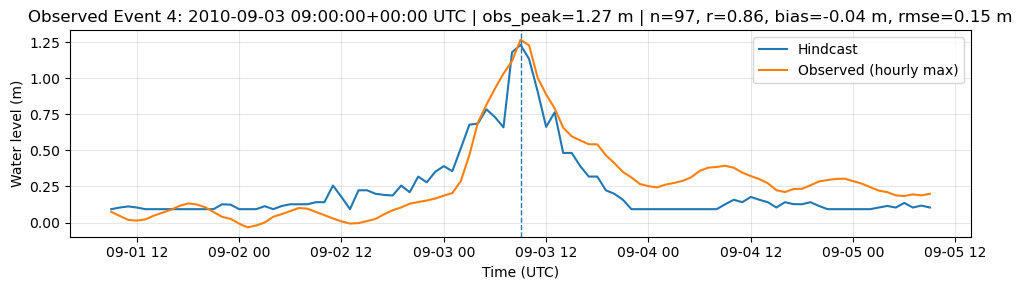

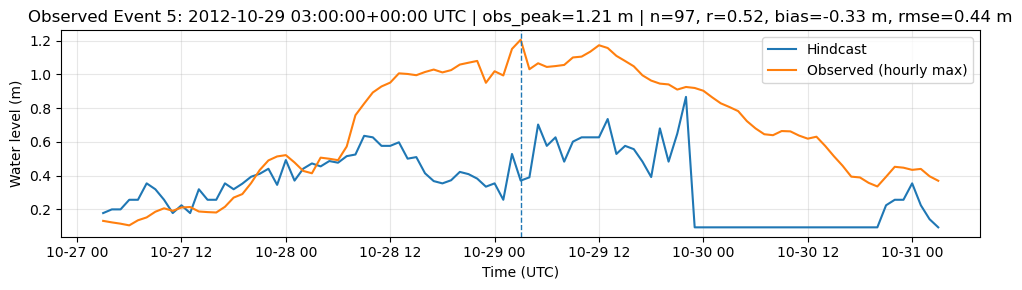

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes you already have `hind` from the prior cell with columns:
#   hind["wl_obs_hr_max_m"]  (observed hourly max WL)
#   hind["wl_pred_m"]        (hindcast WL)
# and a DateTimeIndex in UTC named "time".
#
# Also assumes you still have:
#   EVENT_WINDOW_H, MIN_PEAK_SEP_H

TOP_N_OBS = 5  # top observed events to plot

def event_peaks(series, top_n=5, min_sep_hours=48):
    s = series.dropna().copy()
    if len(s) == 0:
        return []
    cand = s.sort_values(ascending=False)
    chosen = []
    min_sep = pd.Timedelta(hours=min_sep_hours)
    for t, val in cand.items():
        if all(abs(t - tc) > min_sep for tc, _ in chosen):
            chosen.append((t, float(val)))
            if len(chosen) >= top_n:
                break
    return chosen

# ------------------------------------------------------------
# 1) Identify top observed events (declustered)
# ------------------------------------------------------------
obs_peaks = event_peaks(hind["wl_obs_hr_max_m"], top_n=TOP_N_OBS, min_sep_hours=MIN_PEAK_SEP_H)

if len(obs_peaks) == 0:
    raise RuntimeError("No observed events found (wl_obs_hr_max_m is all NaN?).")

print("Top observed events (declustered):")
for i, (tpk, pk) in enumerate(obs_peaks, start=1):
    # report hindcast peak in same window for context
    t1 = tpk - pd.Timedelta(hours=EVENT_WINDOW_H)
    t2 = tpk + pd.Timedelta(hours=EVENT_WINDOW_H)
    sub = hind.loc[t1:t2, ["wl_obs_hr_max_m", "wl_pred_m"]]
    pk_pred = float(sub["wl_pred_m"].max()) if sub["wl_pred_m"].notna().any() else np.nan
    print(f"{i:2d}. {tpk}  obs_peak={pk:.3f} m   max_pred_in_window={pk_pred:.3f} m")

# ------------------------------------------------------------
# 2) Plot short comparisons around each event
# ------------------------------------------------------------
for i, (tpk, pk_obs) in enumerate(obs_peaks, start=1):
    t1 = tpk - pd.Timedelta(hours=EVENT_WINDOW_H)
    t2 = tpk + pd.Timedelta(hours=EVENT_WINDOW_H)

    sub = hind.loc[t1:t2, ["wl_obs_hr_max_m", "wl_pred_m"]].copy()

    # Compute stats where overlap exists in the window
    d = sub.dropna()
    if len(d) >= 5:
        err = d["wl_pred_m"] - d["wl_obs_hr_max_m"]
        bias = float(err.mean())
        rmse = float(np.sqrt((err**2).mean()))
        r = float(np.corrcoef(d["wl_obs_hr_max_m"].values, d["wl_pred_m"].values)[0,1]) if len(d) > 2 else np.nan
        stats_txt = f"n={len(d)}, r={r:.2f}, bias={bias:.2f} m, rmse={rmse:.2f} m"
    else:
        stats_txt = "insufficient overlap for stats"

    plt.figure(figsize=(10, 3))
    plt.plot(sub.index, sub["wl_pred_m"], label="Hindcast")
    plt.plot(sub.index, sub["wl_obs_hr_max_m"], label="Observed (hourly max)")

    # Mark observed peak time
    plt.axvline(tpk, linestyle="--", linewidth=1)

    plt.title(f"Observed Event {i}: {tpk} UTC | obs_peak={pk_obs:.2f} m | {stats_txt}")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Water level (m)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
